In [21]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
from pathlib import Path
from tqdm import tqdm

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as T

# --- Configuration ---
# Set main data directory
DATA_DIR = Path("kaggle-data")
TRAIN_IMG_DIR = DATA_DIR / "train"
VAL_IMG_DIR = DATA_DIR / "val"
TEST_IMG_DIR = DATA_DIR / "test_final"

# Model parameters
NUM_CLASSES = 5 # 4 classes + 1 background
BATCH_SIZE = 8 # Adjust based on your GPU memory
NUM_EPOCHS = 50 # Start with a small number to test the pipeline
LEARNING_RATE = 0.005

# Class mapping
CLASS_MAP = {
    "Epithelial": 1,
    "Lymphocyte": 2,
    "Macrophage": 3,
    "Neutrophil": 4,
}
# Create an inverse map for prediction visualization if needed
INV_CLASS_MAP = {v: k for k, v in CLASS_MAP.items()}

# Set device (MPS for Apple Silicon M-series chips)
# DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
DEVICE = "cpu"
print(f"Using device: {DEVICE}")


# --- RLE Encoding Function (from problem description) ---
def rle_encode_instance_mask(mask: np.ndarray) -> str:
    """
    Convert an instance segmentation mask (H,W) -> RLE triple string.
    0 = background, >0 = instance IDs.
    """
    pixels = mask.flatten(order="F").astype(np.int32)
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    rle = []
    for i in range(len(runs) - 1):
        start = runs[i]
        end = runs[i + 1]
        length = end - start
        val = pixels[start]
        if val > 0:
            rle.extend([val, start, length])
    if not rle:
        return "0"
    return " ".join(map(str, rle))


# --- Custom Dataset Class ---
class NucleiDataset(Dataset):
    def __init__(self, image_dir, transforms=None):
        self.image_dir = Path(image_dir)
        self.transforms = transforms
        
        all_image_files = sorted([f for f in self.image_dir.glob("*.tif")])
        all_xml_files = sorted([f for f in self.image_dir.glob("*.xml")])

        self.image_files = []
        self.xml_files = []
        
        print(f"Filtering dataset in {image_dir}...")
        for img_path, xml_path in tqdm(zip(all_image_files, all_xml_files), total=len(all_image_files)):
            tree = ET.parse(xml_path)
            root = tree.getroot()
            
            # --- KEY FIX (Correct Hierarchy Parsing) ---
            # We need to find at least one ANNOTATION that has a class we care about
            # AND contains at least one REGION.
            has_valid_annotation = False
            
            # Loop over top-level Annotations
            for annotation in root.findall("Annotation"):
                # Find the class name for this ANNOTATION
                attribute = annotation.find("Attributes/Attribute")
                if attribute is None:
                    continue
                
                label_name = attribute.get("Name")
                if label_name in CLASS_MAP:
                    # This annotation is for a class we care about.
                    # Does it contain any regions (instances)?
                    if annotation.find("Regions/Region") is not None:
                         has_valid_annotation = True
                         break # Found a valid class with at least one region, this file is good.
            
            if has_valid_annotation:
                self.image_files.append(img_path)
                self.xml_files.append(xml_path)
        
        print(f"Found {len(self.image_files)} images with valid annotations out of {len(all_image_files)} total.")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        xml_path = self.xml_files[idx]
        
        # Load image
        img = Image.open(img_path).convert("RGB")
        width, height = img.size

        # Parse XML annotations
        tree = ET.parse(xml_path)
        root = tree.getroot()

        masks, labels, boxes = [], [], []
        
        # --- KEY FIX (Correct Hierarchy Parsing) ---
        # Loop over top-level Annotations
        for annotation in root.findall("Annotation"):
            # Find the class name for this ANNOTATION
            attribute = annotation.find("Attributes/Attribute")
            if attribute is None:
                continue
                
            label_name = attribute.get("Name")
            if label_name not in CLASS_MAP:
                continue
            
            # This is a class we care about, e.g., "Epithelial"
            label_id = CLASS_MAP[label_name]

            # Now, find all regions *within this annotation's Regions tag*
            for region in annotation.findall("Regions/Region"):
                vertices = []
                # Try the path from slide1.xml: Region -> Vertices -> Vertex
                vertex_nodes = region.findall("Vertices/Vertex")
                
                if not vertex_nodes:
                    # If that fails, try the other common path: Region -> Vertex
                    vertex_nodes = region.findall("Vertex")

                for vertex in vertex_nodes:
                    x = float(vertex.get("X"))
                    y = float(vertex.get("Y"))
                    vertices.append((x, y))

                if not vertices:
                    # This region has a class but no vertices, skip it.
                    continue

                # Create a binary mask for this single instance
                instance_mask = Image.new("L", (width, height), 0)
                ImageDraw.Draw(instance_mask).polygon(vertices, outline=1, fill=1)
                mask_np = np.array(instance_mask)
                
                # Get bounding box from mask
                pos = np.where(mask_np)
                if pos[0].size == 0 or pos[1].size == 0:
                    continue # Skip empty masks
                xmin, xmax = np.min(pos[1]), np.max(pos[1])
                ymin, ymax = np.min(pos[0]), np.max(pos[0])
                
                # Check for valid box area
                if xmax > xmin and ymax > ymin:
                    masks.append(mask_np)
                    labels.append(label_id)
                    boxes.append([xmin, ymin, xmax, ymax])

        if not boxes: # This should now only happen if a "valid" file has 0-area polygons
            target = {
                "boxes": torch.zeros((0, 4), dtype=torch.float32),
                "labels": torch.zeros(0, dtype=torch.int64),
                "masks": torch.zeros((0, height, width), dtype=torch.uint8)
            }
        else:
            # Convert to tensors
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)

            target = {"boxes": boxes, "labels": labels, "masks": masks}
        
        # Apply transforms
        # For this test, we just convert to tensor
        img_tensor = T.ToImage()(img)
        img_tensor = T.ToDtype(torch.float32, scale=True)(img_tensor)
        
        if self.transforms:
             if 'RandomHorizontalFlip' in str(self.transforms):
                img_tensor, target = self.transforms(img_tensor, target)


        return img_tensor, target

# --- Data Augmentation ---
def get_transforms(is_train):
    transforms = []
    # Converts the image to a PyTorch Tensor
    transforms.append(T.ToImage())
    transforms.append(T.ToDtype(torch.float32, scale=True))
    if is_train:
        # Adds random horizontal flipping for augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# --- Model Definition ---
def get_model(num_classes):
    # Load a pre-trained instance segmentation model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # Replace the box predictor
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Replace the mask predictor
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    
    return model

# --- Utility for DataLoader ---
def collate_fn(batch):
    return tuple(zip(*batch))

# --- Training Loop ---
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    loop = tqdm(data_loader, leave=True)
    total_loss = 0
    
    for images, targets in loop:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
        loop.set_postfix(loss=losses.item())
        
    return total_loss / len(data_loader)

# --- Main Execution Block ---
if __name__ == "__main__":
    
    # 1. Setup Datasets and DataLoaders
    print("Setting up datasets...")
    dataset_train = NucleiDataset(TRAIN_IMG_DIR, transforms=get_transforms(is_train=True))
    dataset_val = NucleiDataset(VAL_IMG_DIR, transforms=get_transforms(is_train=False))

    train_loader = DataLoader(
        dataset_train, batch_size=BATCH_SIZE, shuffle=True, 
        num_workers=0, collate_fn=collate_fn
    )
    val_loader = DataLoader(
        dataset_val, batch_size=1, shuffle=False, 
        num_workers=0, collate_fn=collate_fn
    )

    # 2. Initialize Model, Optimizer
    print("Initializing model...")
    model = get_model(NUM_CLASSES)
    model.to(DEVICE)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005)
    
    # 3. Training
    print("Starting training...")
    for epoch in range(NUM_EPOCHS):
        avg_loss = train_one_epoch(model, optimizer, train_loader, DEVICE)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Average Training Loss: {avg_loss:.4f}")
    
    # Save the trained model
    torch.save(model.state_dict(), "nuclei_maskrcnn_model.pth")
    print("Training finished and model saved.")

    # 4. Prediction/Inference
    print("Starting prediction on the test set...")
    model.eval()
    
    test_files = sorted(list(TEST_IMG_DIR.glob("*.tif")))
    results = []
    
    # Use the transforms for test images (without augmentation)
    test_transforms = get_transforms(is_train=False)

    for img_path in tqdm(test_files):
        img = Image.open(img_path).convert("RGB")
        img_tensor = test_transforms(img)
        
        with torch.no_grad():
            prediction = model([img_tensor.to(DEVICE)])[0]
            
        # Initialize one instance mask per class
        instance_masks = {class_name: np.zeros((img.height, img.width), dtype=np.int32) for class_name in CLASS_MAP.keys()}
        instance_counters = {class_name: 1 for class_name in CLASS_MAP.keys()}

        # Filter predictions by score and process them
        confidence_threshold = 0.5
        scores = prediction['scores'].cpu().numpy()
        high_conf_indices = np.where(scores > confidence_threshold)[0]

        for i in high_conf_indices:
            label_id = prediction['labels'][i].item()
            if label_id not in INV_CLASS_MAP:
                continue
            
            class_name = INV_CLASS_MAP[label_id]
            
            # Get the binary mask by thresholding the soft mask
            mask = prediction['masks'][i, 0].cpu().numpy()
            binary_mask = (mask > 0.5).astype(np.uint8)
            
            # Add instance to the correct class mask with a unique ID
            instance_id = instance_counters[class_name]
            instance_masks[class_name][binary_mask == 1] = instance_id
            instance_counters[class_name] += 1
            
        # RLE encode each class mask
        rle_results = {
            "image_id": img_path.stem,
            "Epithelial": rle_encode_instance_mask(instance_masks["Epithelial"]),
            "Lymphocyte": rle_encode_instance_mask(instance_masks["Lymphocyte"]),
            "Macrophage": rle_encode_instance_mask(instance_masks["Macrophage"]),
            "Neutrophil": rle_encode_instance_mask(instance_masks["Neutrophil"])
        }
        results.append(rle_results)

    # 5. Create Submission CSV
    print("Creating submission file...")
    submission_df = pd.DataFrame(results, columns=["image_id", "Epithelial", "Lymphocyte", "Neutrophil", "Macrophage"])
    submission_df.to_csv("submission_markrcnn.csv", index=False)
    
    print("submission.csv created successfully!")

Using device: cpu
Setting up datasets...
Filtering dataset in kaggle-data/train...


100%|██████████| 209/209 [00:02<00:00, 102.47it/s]


Found 209 images with valid annotations out of 209 total.
Filtering dataset in kaggle-data/val...


100%|██████████| 45/45 [00:00<00:00, 99.40it/s] 


Found 45 images with valid annotations out of 45 total.
Initializing model...
Starting training...


100%|██████████| 27/27 [17:08<00:00, 38.11s/it, loss=3.27]


Epoch 1/50, Average Training Loss: 2.2342


100%|██████████| 27/27 [16:03<00:00, 35.70s/it, loss=1.43]


Epoch 2/50, Average Training Loss: 1.6557


100%|██████████| 27/27 [15:40<00:00, 34.82s/it, loss=1.35]


Epoch 3/50, Average Training Loss: 1.5445


100%|██████████| 27/27 [16:01<00:00, 35.62s/it, loss=1.53]


Epoch 4/50, Average Training Loss: 1.4628


100%|██████████| 27/27 [15:13<00:00, 33.83s/it, loss=1.81]


Epoch 5/50, Average Training Loss: 1.4512


100%|██████████| 27/27 [15:31<00:00, 34.51s/it, loss=2]   


Epoch 6/50, Average Training Loss: 1.4011


100%|██████████| 27/27 [16:07<00:00, 35.82s/it, loss=1.51]


Epoch 7/50, Average Training Loss: 1.3889


100%|██████████| 27/27 [15:59<00:00, 35.54s/it, loss=1.19] 


Epoch 8/50, Average Training Loss: 1.3303


100%|██████████| 27/27 [15:31<00:00, 34.51s/it, loss=2.08]


Epoch 9/50, Average Training Loss: 1.3314


100%|██████████| 27/27 [15:38<00:00, 34.78s/it, loss=1.92]


Epoch 10/50, Average Training Loss: 1.3135


100%|██████████| 27/27 [15:34<00:00, 34.61s/it, loss=1.86]


Epoch 11/50, Average Training Loss: 1.3444


100%|██████████| 27/27 [15:21<00:00, 34.13s/it, loss=0.829]


Epoch 12/50, Average Training Loss: 1.2255


100%|██████████| 27/27 [15:46<00:00, 35.05s/it, loss=1.48]


Epoch 13/50, Average Training Loss: 1.2319


100%|██████████| 27/27 [15:59<00:00, 35.55s/it, loss=1.47] 


Epoch 14/50, Average Training Loss: 1.2259


100%|██████████| 27/27 [15:50<00:00, 35.20s/it, loss=0.875]


Epoch 15/50, Average Training Loss: 1.2494


100%|██████████| 27/27 [15:30<00:00, 34.45s/it, loss=1.39]


Epoch 16/50, Average Training Loss: 1.2831


100%|██████████| 27/27 [15:49<00:00, 35.17s/it, loss=0.913]


Epoch 17/50, Average Training Loss: 1.2089


100%|██████████| 27/27 [15:57<00:00, 35.47s/it, loss=0.895]


Epoch 18/50, Average Training Loss: 1.1872


100%|██████████| 27/27 [15:39<00:00, 34.81s/it, loss=1.79] 


Epoch 19/50, Average Training Loss: 1.2102


100%|██████████| 27/27 [15:42<00:00, 34.90s/it, loss=0.79] 


Epoch 20/50, Average Training Loss: 1.1697


100%|██████████| 27/27 [15:56<00:00, 35.44s/it, loss=0.399]


Epoch 21/50, Average Training Loss: 1.1901


100%|██████████| 27/27 [15:37<00:00, 34.72s/it, loss=1.07] 


Epoch 22/50, Average Training Loss: 1.1972


100%|██████████| 27/27 [15:34<00:00, 34.62s/it, loss=1.09] 


Epoch 23/50, Average Training Loss: 1.1700


100%|██████████| 27/27 [16:12<00:00, 36.01s/it, loss=0.92] 


Epoch 24/50, Average Training Loss: 1.1487


100%|██████████| 27/27 [16:23<00:00, 36.43s/it, loss=1.42]


Epoch 25/50, Average Training Loss: 1.1836


100%|██████████| 27/27 [17:51<00:00, 39.67s/it, loss=0.358]


Epoch 26/50, Average Training Loss: 1.1974


100%|██████████| 27/27 [22:41<00:00, 50.43s/it, loss=0.844]


Epoch 27/50, Average Training Loss: 1.0929


100%|██████████| 27/27 [15:55<00:00, 35.40s/it, loss=1.41] 


Epoch 28/50, Average Training Loss: 1.1003


100%|██████████| 27/27 [23:00<00:00, 51.11s/it, loss=1.16] 


Epoch 29/50, Average Training Loss: 1.1550


100%|██████████| 27/27 [28:58<00:00, 64.40s/it, loss=0.754]


Epoch 30/50, Average Training Loss: 1.1328


100%|██████████| 27/27 [32:22<00:00, 71.94s/it, loss=0.624]


Epoch 31/50, Average Training Loss: 1.1196


100%|██████████| 27/27 [31:36<00:00, 70.23s/it, loss=0.411]


Epoch 32/50, Average Training Loss: 1.1311


100%|██████████| 27/27 [31:50<00:00, 70.74s/it, loss=1.1]  


Epoch 33/50, Average Training Loss: 1.1214


100%|██████████| 27/27 [29:58<00:00, 66.63s/it, loss=0.318]


Epoch 34/50, Average Training Loss: 1.0727


100%|██████████| 27/27 [29:29<00:00, 65.55s/it, loss=0.23] 


Epoch 35/50, Average Training Loss: 1.1051


100%|██████████| 27/27 [29:04<00:00, 64.61s/it, loss=1.75] 


Epoch 36/50, Average Training Loss: 1.1378


100%|██████████| 27/27 [28:58<00:00, 64.37s/it, loss=1.04] 


Epoch 37/50, Average Training Loss: 1.0393


100%|██████████| 27/27 [31:01<00:00, 68.94s/it, loss=1.44] 


Epoch 38/50, Average Training Loss: 1.1099


100%|██████████| 27/27 [31:14<00:00, 69.42s/it, loss=1.5]  


Epoch 39/50, Average Training Loss: 1.1407


100%|██████████| 27/27 [31:22<00:00, 69.71s/it, loss=1.21] 


Epoch 40/50, Average Training Loss: 1.1263


100%|██████████| 27/27 [31:35<00:00, 70.19s/it, loss=1.25] 


Epoch 41/50, Average Training Loss: 1.1008


100%|██████████| 27/27 [30:33<00:00, 67.92s/it, loss=1.89] 


Epoch 42/50, Average Training Loss: 1.0990


100%|██████████| 27/27 [38:14<00:00, 84.99s/it, loss=0.707] 


Epoch 43/50, Average Training Loss: 1.0500


  7%|▋         | 2/27 [03:45<47:02, 112.90s/it, loss=0.832]


KeyboardInterrupt: 

--- Starting Dataset Check ---
Filtering dataset in kaggle-data/train...


100%|██████████| 209/209 [00:01<00:00, 130.14it/s]


Found 209 images with valid annotations out of 209 total.

Searching for the first image with valid annotations...
Found valid image at index 0

--- Diagnostics for Image: slide1.tif ---
Image tensor shape: torch.Size([3, 297, 204])
Target keys: dict_keys(['boxes', 'labels', 'masks'])
Number of instances found: 5
Labels tensor: tensor([3, 3, 3, 3, 3])
Boxes tensor shape: torch.Size([5, 4])
Masks tensor shape: torch.Size([5, 297, 204])

Total sum of all mask pixels: 4853
SUCCESS: Masks are NOT empty and are being loaded correctly.


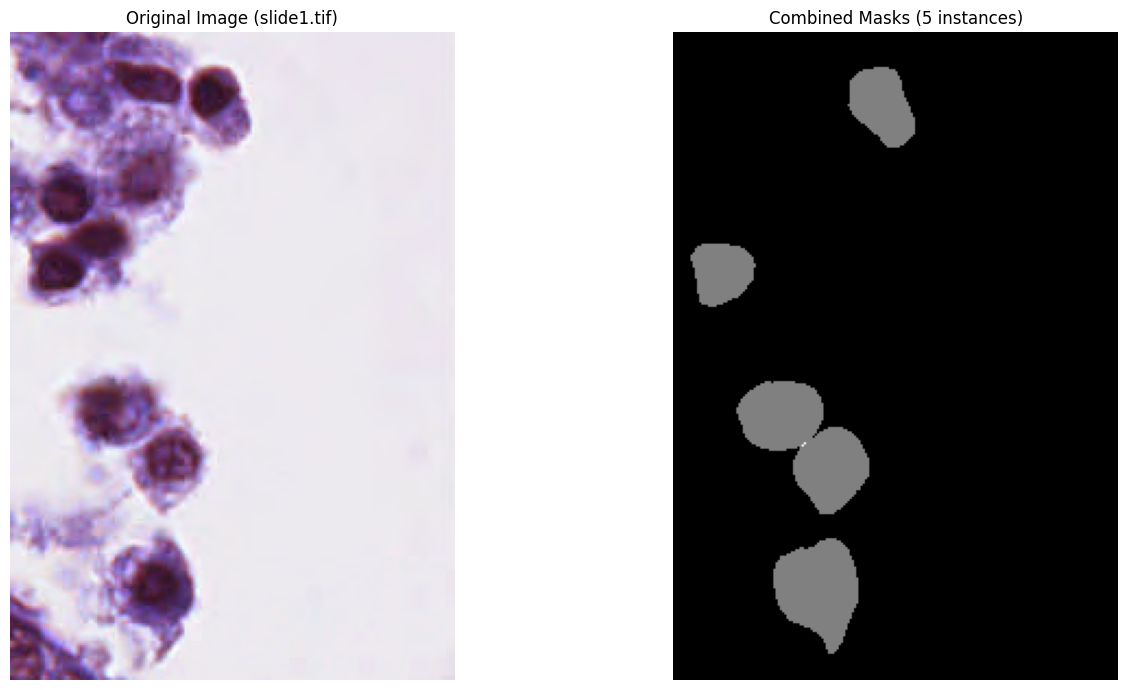

--- Dataset Check Finished ---


In [19]:
import torch
import numpy as np
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
from pathlib import Path
from tqdm import tqdm
from torch.utils.data import Dataset
import torchvision.transforms.v2 as T
import matplotlib.pyplot as plt

# --- Configuration (Copied from main script) ---
DATA_DIR = Path("kaggle-data")
TRAIN_IMG_DIR = DATA_DIR / "train"
CLASS_MAP = {
    "Epithelial": 1,
    "Lymphocyte": 2,
    "Macrophage": 3,
    "Neutrophil": 4,
}

# --- NucleiDataset Class (Copied from main script) ---
# We MUST use the exact same class to verify it
class NucleiDataset(Dataset):
    def __init__(self, image_dir, transforms=None):
        self.image_dir = Path(image_dir)
        self.transforms = transforms
        
        all_image_files = sorted([f for f in self.image_dir.glob("*.tif")])
        all_xml_files = sorted([f for f in self.image_dir.glob("*.xml")])

        self.image_files = []
        self.xml_files = []
        
        print(f"Filtering dataset in {image_dir}...")
        for img_path, xml_path in tqdm(zip(all_image_files, all_xml_files), total=len(all_image_files)):
            tree = ET.parse(xml_path)
            root = tree.getroot()
            
            # --- KEY FIX (Correct Hierarchy Parsing) ---
            # We need to find at least one ANNOTATION that has a class we care about
            # AND contains at least one REGION.
            has_valid_annotation = False
            
            # Loop over top-level Annotations
            for annotation in root.findall("Annotation"):
                # Find the class name for this ANNOTATION
                attribute = annotation.find("Attributes/Attribute")
                if attribute is None:
                    continue
                
                label_name = attribute.get("Name")
                if label_name in CLASS_MAP:
                    # This annotation is for a class we care about.
                    # Does it contain any regions (instances)?
                    if annotation.find("Regions/Region") is not None:
                         has_valid_annotation = True
                         break # Found a valid class with at least one region, this file is good.
            
            if has_valid_annotation:
                self.image_files.append(img_path)
                self.xml_files.append(xml_path)
        
        print(f"Found {len(self.image_files)} images with valid annotations out of {len(all_image_files)} total.")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        xml_path = self.xml_files[idx]
        
        # Load image
        img = Image.open(img_path).convert("RGB")
        width, height = img.size

        # Parse XML annotations
        tree = ET.parse(xml_path)
        root = tree.getroot()

        masks, labels, boxes = [], [], []
        
        # --- KEY FIX (Correct Hierarchy Parsing) ---
        # Loop over top-level Annotations
        for annotation in root.findall("Annotation"):
            # Find the class name for this ANNOTATION
            attribute = annotation.find("Attributes/Attribute")
            if attribute is None:
                continue
                
            label_name = attribute.get("Name")
            if label_name not in CLASS_MAP:
                continue
            
            # This is a class we care about, e.g., "Epithelial"
            label_id = CLASS_MAP[label_name]

            # Now, find all regions *within this annotation's Regions tag*
            for region in annotation.findall("Regions/Region"):
                vertices = []
                # Try the path from slide1.xml: Region -> Vertices -> Vertex
                vertex_nodes = region.findall("Vertices/Vertex")
                
                if not vertex_nodes:
                    # If that fails, try the other common path: Region -> Vertex
                    vertex_nodes = region.findall("Vertex")

                for vertex in vertex_nodes:
                    x = float(vertex.get("X"))
                    y = float(vertex.get("Y"))
                    vertices.append((x, y))

                if not vertices:
                    # This region has a class but no vertices, skip it.
                    continue

                # Create a binary mask for this single instance
                instance_mask = Image.new("L", (width, height), 0)
                ImageDraw.Draw(instance_mask).polygon(vertices, outline=1, fill=1)
                mask_np = np.array(instance_mask)
                
                # Get bounding box from mask
                pos = np.where(mask_np)
                if pos[0].size == 0 or pos[1].size == 0:
                    continue # Skip empty masks
                xmin, xmax = np.min(pos[1]), np.max(pos[1])
                ymin, ymax = np.min(pos[0]), np.max(pos[0])
                
                # Check for valid box area
                if xmax > xmin and ymax > ymin:
                    masks.append(mask_np)
                    labels.append(label_id)
                    boxes.append([xmin, ymin, xmax, ymax])

        if not boxes: # This should now only happen if a "valid" file has 0-area polygons
            target = {
                "boxes": torch.zeros((0, 4), dtype=torch.float32),
                "labels": torch.zeros(0, dtype=torch.int64),
                "masks": torch.zeros((0, height, width), dtype=torch.uint8)
            }
        else:
            # Convert to tensors
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)

            target = {"boxes": boxes, "labels": labels, "masks": masks}
        
        # Apply transforms
        # For this test, we just convert to tensor
        img_tensor = T.ToImage()(img)
        img_tensor = T.ToDtype(torch.float32, scale=True)(img_tensor)
        
        if self.transforms:
             if 'RandomHorizontalFlip' in str(self.transforms):
                img_tensor, target = self.transforms(img_tensor, target)


        return img_tensor, target

# --- Main Execution Block for Testing ---
if __name__ == "__main__":
    print("--- Starting Dataset Check ---")
    
    # You might need to install matplotlib: pip install matplotlib
    
    # 1. Create the dataset instance
    # We pass transforms=None to just get the raw data without augmentations
    dataset = NucleiDataset(TRAIN_IMG_DIR, transforms=None)
    
    if len(dataset) == 0:
        print("\n!!! ERROR: No images with valid annotations were found. Check your CLASS_MAP and XML paths.")
    else:
        # 2. Find the first valid item
        img_tensor, target = None, None
        first_valid_idx = -1
        
        print("\nSearching for the first image with valid annotations...")
        for i in range(len(dataset)):
            img_tensor, target = dataset[i]
            if len(target['labels']) > 0:
                first_valid_idx = i
                break
        
        if first_valid_idx == -1:
            print(f"!!! ERROR: Could not find any images with instances (though dataset has {len(dataset)} files). This is strange.")
        else:
            print(f"Found valid image at index {first_valid_idx}")
            
            # 3. Print Diagnostics
            print(f"\n--- Diagnostics for Image: {dataset.image_files[first_valid_idx].name} ---")
            print(f"Image tensor shape: {img_tensor.shape}")
            print(f"Target keys: {target.keys()}")
            print(f"Number of instances found: {len(target['labels'])}")
            print(f"Labels tensor: {target['labels']}")
            print(f"Boxes tensor shape: {target['boxes'].shape}")
            print(f"Masks tensor shape: {target['masks'].shape}")
            
            # 4. Check if masks are empty
            if len(target['labels']) > 0:
                mask_sum = target['masks'].sum()
                print(f"\nTotal sum of all mask pixels: {mask_sum}")
                if mask_sum > 0:
                    print("SUCCESS: Masks are NOT empty and are being loaded correctly.")
                else:
                    print("ERROR: Masks are empty (all zeros). Check your XML parsing logic.")
            
            # 5. Visualize the data
            if len(target['labels']) > 0:
                # Convert image tensor from (C, H, W) to (H, W, C) for plotting
                img_to_plot = img_tensor.permute(1, 2, 0).numpy()
                
                # Combine all instance masks into one single mask for visualization
                # We sum along the "instance" dimension (axis 0)
                combined_mask_np = target['masks'].sum(axis=0).numpy()
                
                fig, ax = plt.subplots(1, 2, figsize=(15, 7))
                
                ax[0].imshow(img_to_plot)
                ax[0].set_title(f"Original Image ({dataset.image_files[first_valid_idx].name})")
                ax[0].axis('off')
                
                ax[1].imshow(combined_mask_np, cmap='gray') # cmap='gray' shows 0 as black, >0 as white
                ax[1].set_title(f"Combined Masks ({len(target['labels'])} instances)")
                ax[1].axis('off')
                
                plt.tight_layout()
                plt.show()

    print("--- Dataset Check Finished ---")

